In [9]:
import itertools
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import csv

data_folder = '../data/'

metric_memory = "node_avg_memory"

In [10]:
def extract_json_data(report_json):
    task_data = report_json['tasks'][0]['subtasks'][0]['workloads'][0]
    return task_data

def get_task_data_list(task_folders):
    result = list()
    for task_folder in task_folders:
        load_folders = next(os.walk(task_folder))[1]
        load_folders.sort()
        for load_folder in load_folders:
            report_json_file = open(task_folder+'/'+load_folder+'/'+'rally_report.json')
            report_json = json.load(report_json_file)
            result.append(extract_json_data(report_json))
    return result


def get_task_folders(structure, config, concurrency):
    exp_folder = data_folder+structure+'/'+config+"/concurrency_"+str(concurrency)
    task_folders = os.listdir(exp_folder)
    task_folders = ['{0}/{1}'.format(exp_folder, subfold) for subfold in task_folders]
    task_folders.sort()
    return task_folders


def extract_durations(structure, config, concurrency):
    task_folders = get_task_folders(structure, config, concurrency)
    task_data_all = get_task_data_list(task_folders)
    durations = list()
    for task_data in task_data_all:
        for workload_info in task_data['data']:
            durations.append(workload_info['duration'])
    durations = np.array(durations)
    return durations

def extract_metrics(structure, config, concurrency):
    result = dict()
    metric_names = None
    task_folders = get_task_folders(structure, config, concurrency)
    for task_folder in task_folders:
        load_folders = next(os.walk(task_folder))[1]
        load_folders.sort()
        for load_folder in load_folders:
            curr_folder = task_folder + "/" + load_folder+"/labeled_metrics"
            for node in next(os.walk(curr_folder))[1]:
                with open(curr_folder+'/'+node+'/custom_metrics.csv', newline='', encoding='utf-8') as f:
                    reader = csv.reader(f)
                    metric_names = reader.__next__()
                    metrics = list()
                    for row in reader:
                        metrics.append(row)
                    metrics = list(map(list, itertools.zip_longest(*metrics, fillvalue=None)))
                    metrics = dict(zip(metric_names, metrics))
                    result[node.split('.')[0]] = metrics
    # discards no data if jagged and fills short nested lists with None
    return result

In [11]:
def SMA(data, width):
    i = 0
    moving_averages = []
    while i < len(data) - width + 1:
        window = data[i : i + width]
        window_average = round(np.sum(window) / width, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

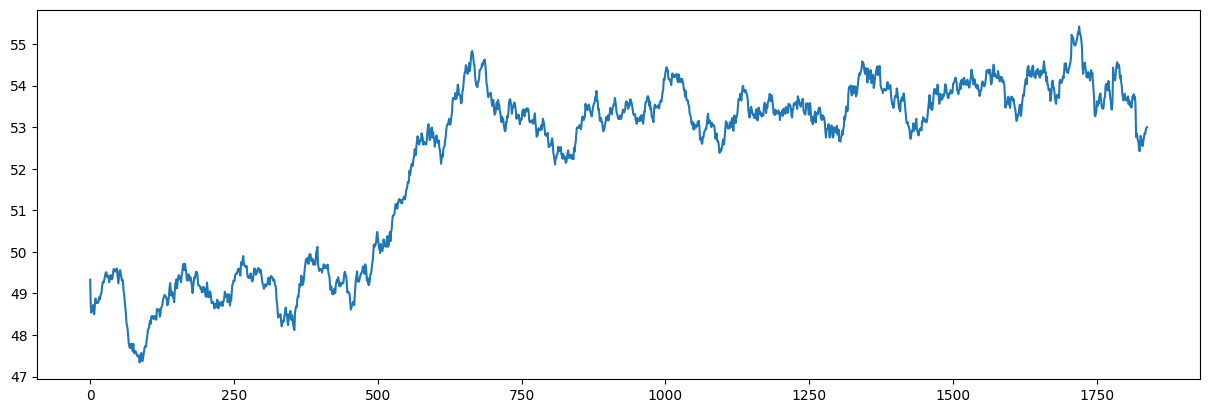

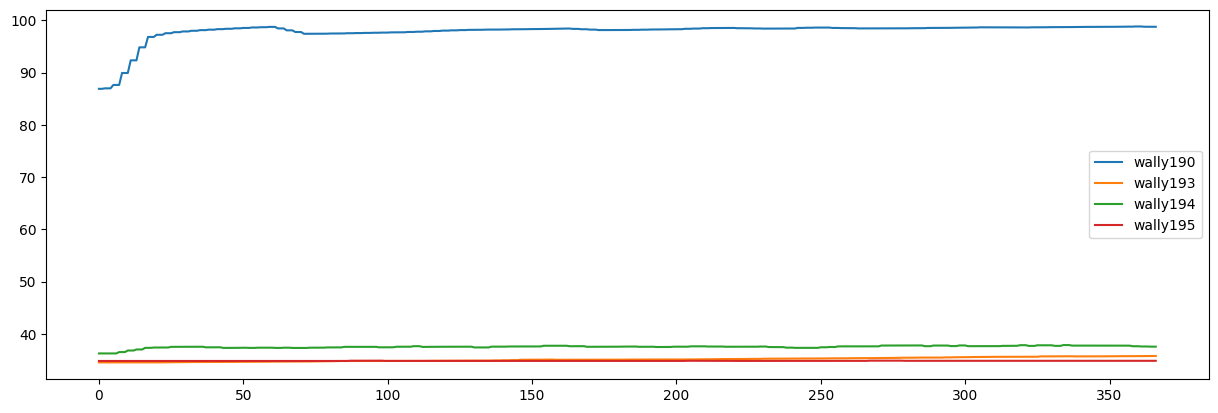

In [14]:

struct = "HA"
config = "wally190"
concurrency = "1"

durations_wally190 = extract_durations(struct, "wally190", concurrency)

plt.figure().set_figwidth(15)
plt.plot(SMA(durations_wally190, 40))
plt.show()

metrics_HA = extract_metrics(struct, "wally190", concurrency)

plt.figure().set_figwidth(15)
for node, metrics in metrics_HA.items():
    plt.plot(SMA(np.array(metrics_HA[node][metric_memory]).astype(float), 1), label=node)
plt.legend()
plt.show()